## Prediction of the final result for an animal in a shelter

### Research plan
    - Dataset and features description
    - Exploratory data analysis
    - Visual analysis of the features
    - Patterns, insights, pecularities of data
    - Data preprocessing
    - Cross-validation, hyperparameter tuning
    - Validation and learning curves
    - Prediction for hold-out and test samples
    - Model evaluation with metrics description
    - Conclusions


### Part 1.  Dataset and features description

Dataset from [Kaggle page](https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-outcomes-and/home). The dataset has the following features:

#### Dataset from Austin Animal Center Shelter contains information about animals in the shelter and their outcome. It is necessary to build a model that predicts the outcome of the animal's stay in the shelter.

You can see the features below:

- __age_upon_outcome__ - Age of the animal at the time at which it left the shelter.
- __animal_id__ 
- __animal_type__ - Cat, dog, or other (including at least one bat!).
- __breed__ - Animal breed. Many animals are generic mixed-breeds, e.g. "Long-haired mix".
- __color__ - Color of the animal's fur, if it has fur.
- __date_of_birth__
- __datetime__
- __monthyear__
- __name__
- __outcome_subtype__
- __outcome_type__ - Ultimate outcome for this animal. Possible entries include transferred, [mercy] euthanized, adopted.
- __sex_upon_outcome__

In [181]:
import pandas as pd
import seaborn as sns
import string
import numpy as np
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import  RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [197]:
path = 'shelter.csv'

In [198]:
df = pd.read_csv(path, parse_dates=['date_of_birth','datetime','monthyear'])
df.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07,2014-07-22 16:04:00,2014-07-22 16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06,2013-11-07 11:47:00,2013-11-07 11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31,2014-06-03 14:20:00,2014-06-03 14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02,2014-06-15 15:50:00,2014-06-15 15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07,2014-07-07 14:04:00,2014-07-07 14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


### Part 2. Exploratory data analysis

We see a mix of categorical, numeric features and a date.
In the task of predicting the outcome of an animal in an orphanage, the target variable is outcome_subtype. outcome_subtype is of several types, so the task is reduced to a multi-class classification

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78256 entries, 0 to 78255
Data columns (total 12 columns):
age_upon_outcome    78248 non-null object
animal_id           78256 non-null object
animal_type         78256 non-null object
breed               78256 non-null object
color               78256 non-null object
date_of_birth       78256 non-null datetime64[ns]
datetime            78256 non-null datetime64[ns]
monthyear           78256 non-null datetime64[ns]
name                54370 non-null object
outcome_subtype     35963 non-null object
outcome_type        78244 non-null object
sex_upon_outcome    78254 non-null object
dtypes: datetime64[ns](3), object(9)
memory usage: 7.2+ MB


1. Many features contain null values, in the future we will correct this.
2. To predict the outcome, we will not use an outcome subtype, so it should be removed.

In [199]:
df.drop('outcome_subtype', axis=1, inplace=True)

Some null values can be filled, for example, with an average or median, but not in the case of the sex_upon_outcome and outcome_type features, because these variables are significant and consist of categorical values, so we also get rid of null values.


In [201]:
df = df[(~df.sex_upon_outcome.isnull()) & (~df.outcome_type.isnull())]
# Empty names fill in "Unknown"
df.name = df.name.fillna('Unknown')

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Let's see on age feature

In [202]:
df.age_upon_outcome.unique()

array(['2 weeks', '1 year', '9 years', '5 months', '4 months', '3 years',
       '1 month', '3 months', '2 years', '2 months', '4 years', '8 years',
       '3 weeks', '8 months', '12 years', '7 years', '5 years', '6 years',
       '5 days', '10 months', '4 weeks', '10 years', '2 days', '6 months',
       '14 years', '11 months', '15 years', '7 months', '13 years',
       '11 years', '16 years', '9 months', '3 days', '6 days', '4 days',
       '5 weeks', '1 week', '1 day', '1 weeks', '0 years', '17 years',
       '20 years', '18 years', '19 years', '22 years', '25 years', nan],
      dtype=object)

Values have a different format: in weeks, days and years. Let's recalculate the age, based on the date of birth and the day of recording information in the file and bring everything to one format - the day. Then we look at the description of the values obtained.

In [203]:
df['age_in_days'] =  (df['datetime'] - df['date_of_birth']).dt.days
df['age_in_days'].describe()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


count    78243.000000
mean       817.050573
std       1077.093633
min       -123.000000
25%         95.000000
50%        371.000000
75%       1096.000000
max       9137.000000
Name: age_in_days, dtype: float64

In [204]:
#Replace negative values with zero.
df[df['age_in_days']<0]=0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [205]:
df.drop('age_upon_outcome', axis=1, inplace=True)
df.drop(['date_of_birth','datetime', 'monthyear'], axis=1, inplace=True)
df.drop('animal_id', axis=1, inplace=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78243 entries, 0 to 78255
Data columns (total 7 columns):
animal_type         78243 non-null object
breed               78243 non-null object
color               78243 non-null object
name                78243 non-null object
outcome_type        78243 non-null object
sex_upon_outcome    78243 non-null object
age_in_days         78243 non-null int64
dtypes: int64(1), object(6)
memory usage: 4.8+ MB


Now all features do not have empty values and we can proceed to further actions.

In [207]:
df.nunique()

animal_type             6
breed                2129
color                 526
name                14576
outcome_type           10
sex_upon_outcome        6
age_in_days          4385
dtype: int64

Let's try to perform the conversion on string features, maybe it will reduce the number of unique values

In [208]:
def punctuation_free(text):
    text = text.replace('/', ' ')
    return ''.join([char for char in text if char not in string.punctuation])

In [212]:
df = df[df.animal_type!=0]

In [213]:
strings = ['animal_type','breed','color','name']
for i in strings:
    df[i] = df[i].apply(lambda x: punctuation_free(x.lower()))
df.nunique()

animal_type             5
breed                2128
color                 524
name                11739
outcome_type            9
sex_upon_outcome        5
age_in_days          4385
dtype: int64

Indeed, this transformation has helped us reduce the number of unique values. You can try to apply any other transformations, but we will stop there and go ahead.

In [214]:
df['outcome_type'].value_counts()

Adoption           33109
Transfer           23496
Return to Owner    14352
Euthanasia          6079
Died                 680
Disposal             307
Rto-Adopt            150
Missing               46
Relocate              16
Name: outcome_type, dtype: int64

### Part 3. Visual analysis of the features

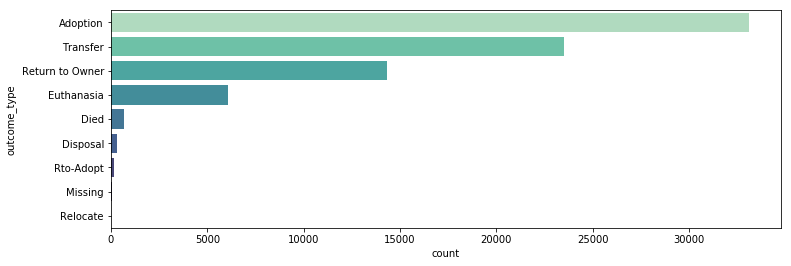

In [215]:
plt.figure(figsize=(12,4))
sns.countplot(y=df['outcome_type'], 
              palette='mako_r',
              order=df['outcome_type'].value_counts().index)
plt.show()

We see that in most animals a good result, since adoption takes the largest share, and negative results are very rare. In this case, we see that the classes are not really balanced, and the fact that they have not so many opportunities to work, it seems that it is correct to predict death or any of these unlikely results will be a problem.

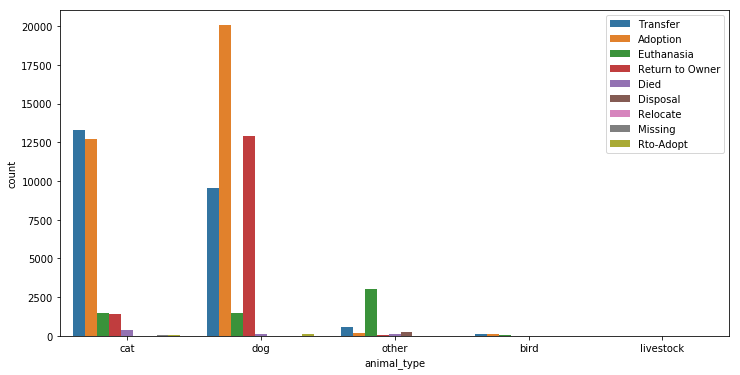

In [216]:
plt.figure(figsize=(12,6))
sns.countplot(data=df,
              x='animal_type',
              hue='outcome_type')
plt.legend(loc='upper right')
plt.show()

It seems that the distribution of results also differs from animal types; we can clearly see that dogs are more likely to be returned to the owner and are attached than cats. And animals from another category are more likely to be euthanized than any other result.

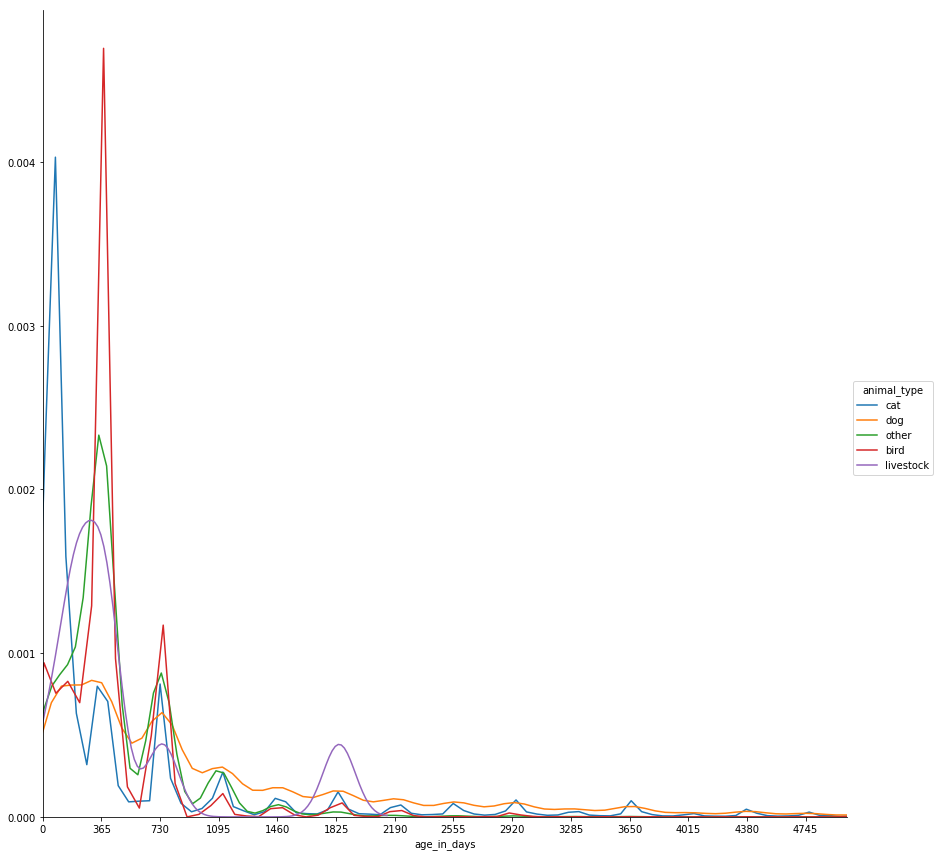

In [217]:
g = sns.FacetGrid(df, hue="animal_type", size=12)
g.map(sns.kdeplot, "age_in_days") 
g.add_legend()
g.set(xlim=(0,5000), xticks=range(0,5000,365))
plt.show(g)

We can see the trend here, if we look more closely, we will see that these peaks occur in what would be when the animal has completed another year. It makes sense if we think that animal shelters will make cutoffs for age when deciding what to do with an animal. For example, when an animal completes 4 years, and they suffer it. Or maybe they don’t know the exact age of the animal, so the “Date of Birth” column, from which we calculated our dates, is only an approximation.

It seems that most cats are adopted during the first months, we also see that there is an annual trend, and that there are many deliverables in the first year. 

### Part 3. Patterns, insights, pecularities of data

Since we have categorical data, it is necessary to encode them, including the target variable
For the target, we will use the Label Encoder, for the other categorical features we compare two ways: 
- get dummies + LabelEncoder 
- LabelEncoder only

### Part 4. Data preprocessing

In [220]:
df.head()

,animal_type,breed,color,name,outcome_type,sex_upon_outcome,age_in_days
0,cat,domestic shorthair mix,orange tabby,unknown,Transfer,Intact Male,15
1,dog,beagle mix,white brown,lucy,Transfer,Spayed Female,366
2,dog,pit bull,blue white,johnny,Adoption,Neutered Male,429
3,dog,miniature schnauzer mix,white,monday,Transfer,Neutered Male,3300
4,other,bat mix,brown,unknown,Euthanasia,Unknown,181


In [223]:
df.sex_upon_outcome.unique()

array(['Intact Male', 'Spayed Female', 'Neutered Male', 'Unknown',
       'Intact Female'], dtype=object)

sex_upon_outcomeLet's add new features for sex instead of sex_upon_outcome

In [224]:
df['Intact'] = df.sex_upon_outcome.apply(lambda x: 1 if 'Intact' in x else 0)
df['Spayed'] = df.sex_upon_outcome.apply(lambda x: 1 if 'Spayed' in x else 0)
df['Neutered'] = df.sex_upon_outcome.apply(lambda x: 1 if 'Neutered' in x else 0)
df['Male'] = df.sex_upon_outcome.apply(lambda x: 1 if 'Male' in x else 0)
df['Female'] = df.sex_upon_outcome.apply(lambda x: 1 if 'Female' in x else 0)
df['Unknown_sex'] = df.sex_upon_outcome.apply(lambda x: 1 if 'Unknown' in x else 0)

In [227]:
df = df.drop('sex_upon_outcome', axis = 1)
df.head()

,animal_type,breed,color,name,outcome_type,age_in_days,Intact,Spayed,Neutered,Male,Female,Unknown_sex
0,cat,domestic shorthair mix,orange tabby,unknown,Transfer,15,1,0,0,1,0,0
1,dog,beagle mix,white brown,lucy,Transfer,366,0,1,0,0,1,0
2,dog,pit bull,blue white,johnny,Adoption,429,0,0,1,1,0,0
3,dog,miniature schnauzer mix,white,monday,Transfer,3300,0,0,1,1,0,0
4,other,bat mix,brown,unknown,Euthanasia,181,0,0,0,0,0,1


In [262]:
X_df = df.drop('outcome_type', axis=1)[:20000]
y_df = df['outcome_type'][:20000]

Let's try to apply LaberEncoder to features.
For faster calculations, reduce the sample size (no need to do that if you have enough power)

In [263]:
le = LabelEncoder()

X_df.name = le.fit_transform(X_df['name'])
X_df.animal_type = le.fit_transform(X_df['animal_type'])
X_df.color = le.fit_transform(X_df['color'])
X_df.breed = le.fit_transform(X_df['breed'])

In [264]:
y_df = le.fit_transform(y_df)

In [265]:
X_df.head()

,animal_type,breed,color,name,age_in_days,Intact,Spayed,Neutered,Male,Female,Unknown_sex
0,1,546,205,4508,15,1,0,0,1,0,0
1,2,161,301,2493,366,0,1,0,0,1,0
2,2,924,78,2043,429,0,0,1,1,0,0
3,2,859,290,2858,3300,0,0,1,1,0,0
4,4,143,79,4508,181,0,0,0,0,0,1


### Model selection 


#### There are many different models for solving classification problems. For this task, it is proposed to evaluate the performance of models:
 - KNeighborsClassifier
 - RandomForestClassifier
 - GradientBoostingClassifier
 
 We will configure the hyperparameters for the model that gives the best results

In [266]:
knc = KNeighborsClassifier()
rfc = RandomForestClassifier(random_state=17)
gbc = GradientBoostingClassifier(random_state=17)

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3)

In [147]:
algos = []
predictions = []
data = []
algos.append(knc)
algos.append(rfc)
algos.append(gbc)
for i in algos:
    i.fit(X_train, y_train)
    data.append({'accuracy_score': accuracy_score(i.predict(X_test), y_test)})
results = pd.DataFrame(data=data, columns=['accuracy_score'],
                       index=['KNeighborsClassifier', 'RandomForestClassifier', 
                              'GradientBoostingClassifier'])

results   

,accuracy_score
KNeighborsClassifier,0.565167
RandomForestClassifier,0.649500
GradientBoostingClassifier,0.694833


Let's try to encode the data using pd.get_dummies, let's see how the quality of the models will change

In [246]:
X_df = df.drop('outcome_type', axis=1)[:10000]
X_df = pd.get_dummies(X_df, columns=['animal_type','color','breed'])
X_df.name = le.fit_transform(X_df['name'])
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3)

In [152]:
algos = []
predictions = []
data = []
algos.append(knc)
algos.append(rfc)
algos.append(gbc)
for i in algos:
    i.fit(X_train, y_train)
    data.append({'accuracy_score': accuracy_score(i.predict(X_test), y_test)})
results = pd.DataFrame(data=data, columns=['accuracy_score'],
                       index=['KNeighborsClassifier', 'RandomForestClassifier', 
                              'GradientBoostingClassifier'])

results   

,accuracy_score
KNeighborsClassifier,0.590167
RandomForestClassifier,0.644667
GradientBoostingClassifier,0.684167


Even with a small amount of data, the model has been trained much longer than the first way.
You may notice that the KN classifier has become more accurate to make a forecast, but nevertheless, Gradient Boosting Classifier copes with this task better in both cases than other models. Also, the result using the LabelEncoder is higher than using get_dummies.
So, let's take the entire amount of test data with Gradient Boosting Classifier and LabelEncoder and set up hypermarameters on Cross-validation

### Part 6. Cross-validation, hyperparameter tuning

In [237]:
#we take more data
X_df = df.drop('outcome_type', axis=1)[:10000]
y_df = df['outcome_type'][:10000]
X_df.name = le.fit_transform(X_df['name'])
X_df.animal_type = le.fit_transform(X_df['animal_type'])
X_df.color = le.fit_transform(X_df['color'])
X_df.breed = le.fit_transform(X_df['breed'])
y_df = le.fit_transform(y_df)

In [269]:
X_df.shape

(1000, 348)

In [270]:
params_grid = {'max_features': [100, 200,348]}
model_grid = GridSearchCV(gbc,params_grid, cv=5)
model_grid.fit(X_train, y_train)
model_grid.best_params_

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


{'max_features': 200}

### Part 7. Validation and learning curves

In [161]:
from sklearn.metrics import make_scorer

# Create scorer with our accuracy-function
scorer = make_scorer(accuracy_score, greater_is_better=True)

In [273]:
X_df = df.drop('outcome_type', axis=1)[:1000]
y_df = df['outcome_type'][:1000]
X_df = pd.get_dummies(X_df, columns=['animal_type','color','breed'])
X_df.name = le.fit_transform(X_df['name'])
y_df = le.fit_transform(y_df)
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3)

max_depth_list = [25, 35,45]
cv_errors_list = []
train_errors_list = []
valid_errors_list = []

for max_depth in max_depth_list:
    gbc = GradientBoostingClassifier(max_depth=max_depth,random_state=17, max_features = 200)

    cv_errors = cross_val_score(estimator=gbc, 
                                  X=X_train, 
                                  y=y_train, 
                                  scoring=scorer,
                                  cv=3)  
    cv_errors_list.append(cv_errors.mean())
    
    gbc.fit(X=X_train, y=y_train)
    train_error = accuracy_score(y_train, gbc.predict(X_train))   
    train_errors_list.append(train_error)
    valid_error = accuracy_score(y_test, gbc.predict(X_test))    
    valid_errors_list.append(valid_error)
    
    print(max_depth)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


25


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


35


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


45


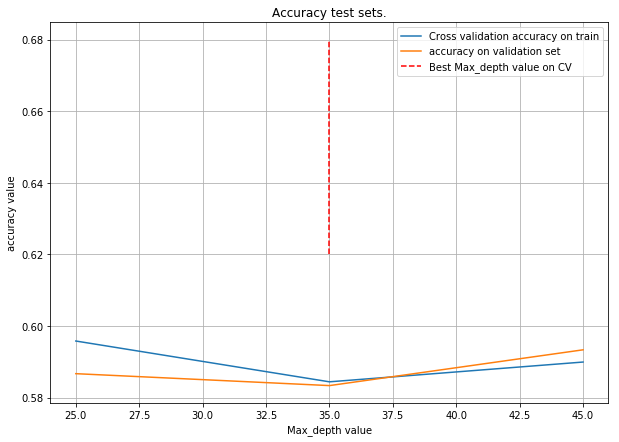

In [274]:
plt.figure(figsize=(10, 7))

plt.plot(max_depth_list,cv_errors_list)
plt.plot(max_depth_list,valid_errors_list)
plt.vlines(x=max_depth_list[np.array(cv_errors_list).argmin()], 
           ymin=0.62, ymax=0.68, 
           linestyles='dashed', colors='r')

plt.legend(['Cross validation accuracy on train', 
            'accuracy on validation set', 
            'Best Max_depth value on CV'])
plt.title("Accuracy test sets.")
plt.xlabel('Max_depth value')
plt.ylabel('accuracy value')
plt.grid()

In [288]:
gbc = GradientBoostingClassifier(random_state=17, max_features = 200)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=200, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=17, subsample=1.0, verbose=0,
              warm_start=False)

In [289]:
accuracy_score(gbc.predict(X_test), y_test)

0.64

### Part 7. Conclusions

We got a good result, but we should carry out a more detailed setting of the hyperparameters and use the full amount of data in the learning process. The solution may be useful for shelters that collect such data and try to predict the approximate result of the animal detection in the shelter. This is important because it allows them to understand which signs more affect the positive outcome for animals and which ones promise more negative.